<a href="https://colab.research.google.com/github/hrishipoola/Customer_RFMT_Metrics_Segmentation/blob/main/Customer_RFMT_Metrics_%26_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer RFMT Metrics & Segmentation

## Table of Contents

1. Introduction
2. Install & Import Packages
3. Load & Process Data
<br> Orders
<br> Payments
<br> Outliers
<br> Merge
4. Create RFMT Metrics
5. Manually Segment & Score
6. K-means Clustering
<br> Box Cox Transformation
<br> Scaling
<br> Optimal K
<br> Fit
7. Segments
<br> Snake Plot
<br> Relative Importants of Metrics
8. References



## 1. Introduction

Today, we'll construct recency, frequency, monetary value, and tenure (RFMT) metrics and segments using Brazilian ecommerce marketplace [Olist's sales transactions data](https://www.kaggle.com/olistbr/brazilian-ecommerce?select=olist_orders_dataset.csv) dating from October 2016 to October 2018. 

RFMT metrics can be used to segment customers in order to identify which customers are responsive to marketing, engaged, contribute to churn, high spenders vs. low-value purchasers, or have upselling or cross-selling potential. Understanding segments can help us better tailor product, sales, and marketing activities and investments. For example, at-risk customers may have high monetary value and frequency, but weak recency and could be targeted with promotions and renewals. In our case, we'll define our metrics as:

- Recency: days since last transaction (delivery)
- Frequency: number of transactions during time period
- Monetary value: total spend during time period
- Tenure: days since first purchase order 

To construct RFMT metrics, we'll need order id, purchase history, order status, delivery dates, and spend details by unique customer id. Olist's data schema shows that the orders data set contains unique customer ids, order status, and delivery dates, while the payments data set contains spend. Let's merge these two data sets together on order id to get what we need. 

We'll use RFMT metrics to segment customers, first manually by building RFMT scores along with arbitrary cutoffs and then using K-means clustering to uncover segemnts in the data (an alternative to K-means would be non-zero matrix factorization (NMF)). We'll then compare our 4 resulting segments and relative importance of segment metrics. 

Future areas to explore:

- Tailor metrics to product categories. For example, we could weight R and F higher and M lower for FMCG (e.g., cosmetics, headphones), while weighting M higher and R and F lower for durable goods (e.g., washing machines)
- Merge [marketing funnel data set](https://www.kaggle.com/olistbr/marketing-funnel-olist/home) to understand and model how customer journey shapes purchasing behavior 

## 2. Install & Import Packages

In [2]:
import pandas as pd
import numpy as np
from datetime import date, timedelta
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
sns.set_style("darkgrid")
style.use('fivethirtyeight')

import io
from io import BytesIO
from zipfile import ZipFile

In [3]:
# Mount google drive
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


## 3. Load & Process Data

### Orders

In [4]:
from google.colab import files
uploaded = files.upload()

Saving olist_orders_dataset.csv.zip to olist_orders_dataset.csv.zip


In [5]:
# Read in csv zip file 
zipfile = ZipFile(BytesIO(uploaded['olist_orders_dataset.csv.zip']))
orders = pd.read_csv(zipfile.open('olist_orders_dataset.csv'))
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [7]:
# Double-check for duplicate orders - there are no duplicates
orders.duplicated().value_counts()

False    99441
dtype: int64

In [8]:
# Convert date columns to datetime format
dates = ['order_purchase_timestamp',
          'order_approved_at', 
          'order_delivered_carrier_date',
          'order_delivered_customer_date', 
          'order_estimated_delivery_date']

for col in dates:
    orders[col] = pd.to_datetime(orders[col])

orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [9]:
orders['order_status'].value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [10]:
# Filter orders
delivered = orders.query('order_status == "delivered"')

In [11]:
delivered.isnull().sum()

order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
dtype: int64

### Payments

In [12]:
from google.colab import files
uploaded = files.upload()

Saving olist_order_payments_dataset.csv.zip to olist_order_payments_dataset.csv.zip


In [13]:
# Read in csv zip file 
zipfile = ZipFile(BytesIO(uploaded['olist_order_payments_dataset.csv.zip']))
payments = pd.read_csv(zipfile.open('olist_order_payments_dataset.csv'))
payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [14]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [15]:
# Double-check for duplicate orders - there are no duplicates
payments.duplicated().value_counts()

False    103886
dtype: int64

In [16]:
# Keep only non-zero payment values
payments = payments.query('payment_value > 0')
payments.describe()

,payment_sequential,payment_installments,payment_value
count,103877.000000,103877.000000,103877.000000
mean,1.092340,2.853509,154.113732
std,0.704312,2.687112,217.498755
min,1.000000,0.000000,0.010000
25%,1.000000,1.000000,56.820000
50%,1.000000,1.000000,100.000000
75%,1.000000,4.000000,171.840000
max,29.000000,24.000000,13664.080000


### Outliers

Let's take a look at payment value outliers (beyond 3 standard deviations). 

Text(0.5, 1.0, 'Distribution of Payment Values')

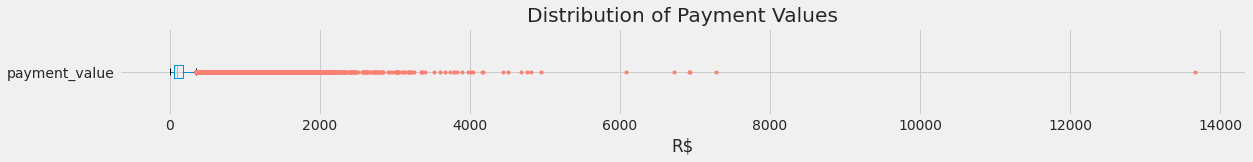

In [17]:
# Box plot: distribution is skewed with higher end outliers 
square = dict(markerfacecolor='salmon', markeredgecolor='salmon', marker='.')
payments.payment_value.plot(kind='box', vert=False, flierprops=square, figsize=(18,1.5))
plt.xlabel('R$')
plt.title('Distribution of Payment Values')

In [18]:
# Remove outliers (beyond 3 standard deviations)
z = np.abs(stats.zscore(payments['payment_value']))
payments_filtered = payments[(z < 3)]
outliers = payments[(z > 3)] # Keep the outliers as a separate dataframe in case we want to explore them

print('There are {} outlier payment values.'.format(outliers.shape[0]))

There are 1803 outlier payment values.


In [19]:
# Payments with outliers removed is less skewed
payments_filtered.payment_value.describe()

count    102074.000000
mean        133.246549
std         119.365471
min           0.010000
25%          56.245000
50%          98.510000
75%         166.645000
max         806.460000
Name: payment_value, dtype: float64

Text(0.5, 1.0, 'Distribution of Payment Values Ex-Outliers')

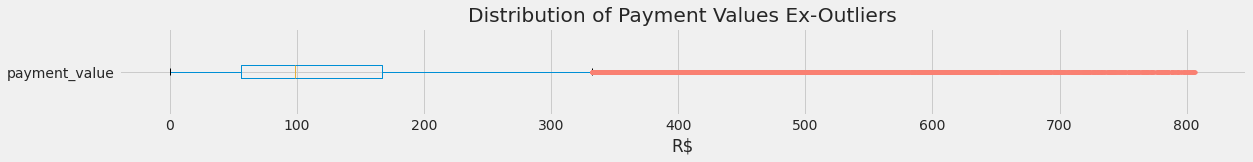

In [20]:
# Box plot: distribution is skewed with higher end outliers 
square = dict(markerfacecolor='salmon', markeredgecolor='salmon', marker='.')
payments_filtered.payment_value.plot(kind='box', vert=False, flierprops=square, figsize=(18,1.5))
plt.xlabel('R$')
plt.title('Distribution of Payment Values Ex-Outliers')

Text(0.5, 11.11999999999999, 'R$')

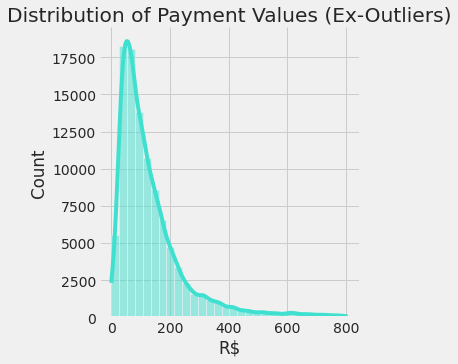

In [21]:
# Plot distribution
sns.displot(payments_filtered['payment_value'],bins=30, kde=True, color='turquoise')
plt.title('Distribution of Payment Values (Ex-Outliers)')
plt.xlabel('R$')

Text(0.5, 11.11999999999999, 'R$')

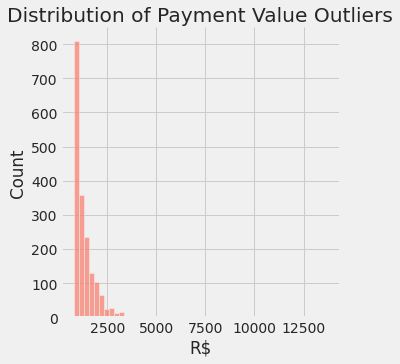

In [22]:
# Plot distribution
sns.displot(outliers['payment_value'],bins=50, color='salmon')
plt.title('Distribution of Payment Value Outliers')
plt.xlabel('R$')

Let's actually keep the outliers in as they could represent an important group of customers to understand and segment. 

In the future, we could remove the outliers and run a further analysis and segmentation focusing only on core customers. We could also dive into the outlier group itself. 

### Merge

In [23]:
# Merge delivered and payments
df = delivered.merge(payments, on ='order_id',how = 'outer')
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,credit_card,1.0,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,3.0,voucher,1.0,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2.0,voucher,1.0,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,boleto,1.0,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,credit_card,3.0,179.12


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103878 entries, 0 to 103877
Data columns (total 12 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       103878 non-null  object        
 1   customer_id                    100753 non-null  object        
 2   order_status                   100753 non-null  object        
 3   order_purchase_timestamp       100753 non-null  datetime64[ns]
 4   order_approved_at              100739 non-null  datetime64[ns]
 5   order_delivered_carrier_date   100751 non-null  datetime64[ns]
 6   order_delivered_customer_date  100745 non-null  datetime64[ns]
 7   order_estimated_delivery_date  100753 non-null  datetime64[ns]
 8   payment_sequential             103877 non-null  float64       
 9   payment_type                   103877 non-null  object        
 10  payment_installments           103877 non-null  float64       
 11  

In [25]:
print('Delivery timestamps range from {} to {}.'.format(min(df.order_delivered_customer_date), max(df.order_delivered_customer_date))) 

Delivery timestamps range from 2016-10-11 13:46:32 to 2018-10-17 13:22:46.


## 4. Create RFMT Metrics




In [26]:
# RFMT metrics
snapshot_date = df['order_delivered_customer_date'].max() + timedelta(days=1)
rfmt = df.groupby('customer_id') \
         .agg({'order_delivered_customer_date': lambda x: (snapshot_date - x.max()).days, # recency
               'order_id': 'count', # frequency
               'payment_value': 'sum', # monetary value
               'order_purchase_timestamp': lambda x: (snapshot_date - x.min()).days # tenure
              }) 

rfmt.dropna(inplace=True)
rfmt = rfmt.query('payment_value > 0') # keep only non-zero monetary values, box cox transformation requires positive values
rfmt.columns = ['recency','frequency','monetary_value','tenure']

## 5. Manually Segment & Score

In [27]:
# Recency
recency_labels = range(3,0,-1) # low recency is better than high recency
recency_group = pd.qcut(rfmt['recency'], 3, labels=recency_labels, duplicates='drop')

# Frequency
frequency_labels = range(1,2)
frequency_group = pd.qcut(rfmt['frequency'], 1, labels=frequency_labels, duplicates='drop')

# Monetary value
monetary_labels = range(1,5)
monetary_group = pd.qcut(rfmt['monetary_value'], 4, labels=monetary_labels, duplicates='drop')

# Tenure
tenure_labels = range(1,5)
tenure_group = pd.qcut(rfmt['tenure'], 4, labels=tenure_labels, duplicates='drop')

rfmt = rfmt.assign(R=recency_group.values, F=frequency_group.values, M=monetary_group.values, T=tenure_group.values)

rfmt['RFMT_Segment'] = rfmt['R'].astype(str) + rfmt['F'].astype(str) + rfmt['M'].astype(str) + rfmt['T'].astype(str)
rfmt['RFMT_Score'] = rfmt[['R','F','M','T']].sum(axis=1)
rfmt

,recency,frequency,monetary_value,tenure,R,F,M,T,RFMT_Segment,RFMT_Score
customer_id,,,,,,,,,,
00012a2ce6f8dcda20d059ce98491703,323.0,1,114.74,337,2,1,3,3,2133,9
000161a058600d5901f007fab4c27140,449.0,1,67.41,459,1,1,2,4,1124,8
0001fd6190edaaf884bcaf3d49edf079,591.0,1,195.42,597,1,1,4,4,1144,10
0002414f95344307404f0ace7a26f1d5,399.0,1,179.35,428,1,1,4,4,1144,10
000379cdec625522490c315e70c7a9fb,187.0,1,107.01,198,3,1,3,2,3132,9
...,...,...,...,...,...,...,...,...,...,...
fffcb937e9dd47a13f05ecb8290f4d3e,210.0,1,91.91,215,2,1,2,2,2122,7
fffecc9f79fd8c764f843e9951b11341,190.0,3,81.36,202,2,1,2,2,2122,7
fffeda5b6d849fbd39689bb92087f431,131.0,1,63.13,148,3,1,2,1,3121,7


In [28]:
# 10 largest RFMT segments
rfmt.groupby('RFMT_Segment').size().sort_values(ascending=False)[:10]

RFMT_Segment
1114    6219
3141    6189
3131    6175
1124    6172
3111    5917
3121    5904
1144    5847
1134    5732
2112    4282
2123    4109
dtype: int64

In [29]:
rfmt.groupby('RFMT_Score').agg({'recency':'mean',
                                'frequency':'mean',
                                'monetary_value':['mean','count'],
                                'tenure': 'mean'
                                }).round(1)

recency frequency monetary_value        tenure
              mean      mean           mean  count   mean
RFMT_Score                                               
6            184.4       1.0           42.8  12191  194.3
7            282.5       1.0           62.3  23752  294.2
8            276.0       1.0          109.3  24437  288.7
9            272.5       1.0          257.7  23993  285.9
10           365.6       1.0          377.5  12090  381.1
11           209.7       1.0          463.5      6  327.0

In [30]:
def segment_name(df):
  if df['RFMT_Score'] >= 10:
    return 'Gold'
  elif df['RFMT_Score'] >=8 and df['RFMT_Score'] <=10:
    return 'Silver'
  else:
    return 'Bronze'   

rfmt['Segment_Name'] = rfmt.apply(segment_name, axis=1)

rfmt.groupby('Segment_Name').agg({'recency':'mean',
                                  'frequency':'mean',
                                  'monetary_value':['mean','count'],
                                  'tenure':'mean'
                                 }).round(1)

recency frequency monetary_value        tenure
                mean      mean           mean  count   mean
Segment_Name                                               
Bronze         249.2       1.0           55.7  35943  260.3
Gold           365.5       1.0          377.6  12096  381.0
Silver         274.2       1.0          182.8  48430  287.4

## 6. K-means clustering

Instead of manually segmenting and scoring using arbitrary cutoffs, let's apply K-means clustering to uncover segments with distinct purchasing behavior. 



### Box Cox Transformation

K-means requires that variables have symmetric (non-skewed) distribution, the same mean, and the same variance. Let's unskew our data using Box Cox transformation and scale it to normalize our RFMT metrics with mean around 0 and st dev around 1. 

In [31]:
# RFMT metrics
snapshot_date = df['order_delivered_customer_date'].max() + timedelta(days=1)
rfmt = df.groupby('customer_id') \
         .agg({'order_delivered_customer_date': lambda x: (snapshot_date - x.max()).days, # recency
               'order_id': 'count', # frequency
               'payment_value': 'sum', # monetary value
               'order_purchase_timestamp': lambda x: (snapshot_date - x.min()).days # tenure
              }) 

rfmt.dropna(inplace=True)
rfmt = rfmt.query('payment_value > 0') # keep only non-zero monetary values
rfmt.columns = ['recency','frequency','monetary_value','tenure']

Text(0.5, 1.0, 'Tenure')

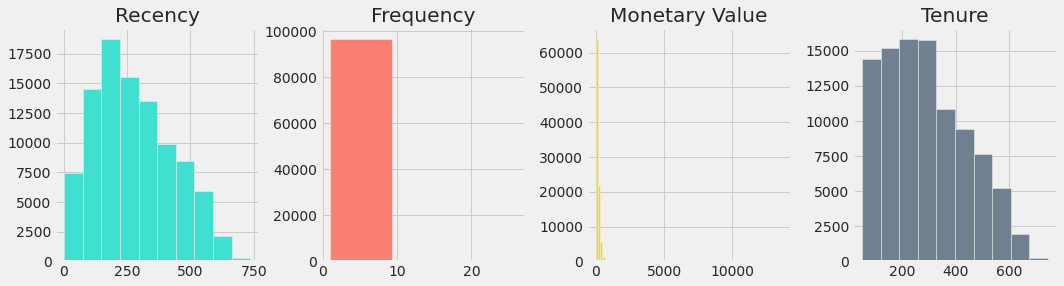

In [32]:
fig, axes = plt.subplots(1, 4, figsize=(16,4))

rfmt.hist('recency', bins=10, color='turquoise', ax=axes[0])
rfmt.hist('frequency', bins=3, color='salmon', ax=axes[1])
rfmt.hist('monetary_value', bins=100, color='gold',ax=axes[2])
rfmt.hist('tenure', bins=10, color='slategray',ax=axes[3])

axes[0].set_title('Recency')
axes[1].set_title('Frequency')
axes[2].set_title('Monetary Value')
axes[3].set_title('Tenure')

RFM variables are skewed, particularly frequency and monetary value. 

In [33]:
def boxcox_df(x):
  # Since stats.boxcox returns 2 objects, this function can be applied to a dataframe and returns 1 object 
  x_boxcox, _ = stats.boxcox(x) # we don't care about second object 
  return x_boxcox

rfmt_boxcox = rfmt.apply(boxcox_df, axis=0)

Text(0.5, 1.0, 'Box Cox Tenure')

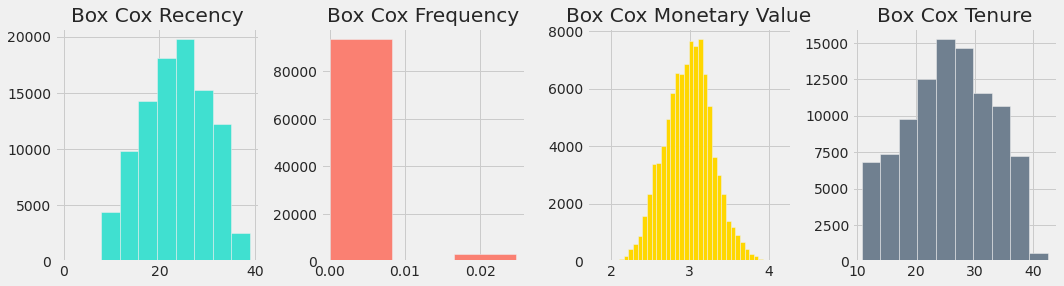

In [34]:
fig, axes = plt.subplots(1, 4, figsize=(16,4))

rfmt_boxcox.hist('recency', bins=10, color='turquoise', ax=axes[0])
rfmt_boxcox.hist('frequency', bins=3, color='salmon', ax=axes[1])
rfmt_boxcox.hist('monetary_value', bins=40, color='gold',ax=axes[2])
rfmt_boxcox.hist('tenure', bins=10, color='slategray',ax=axes[3])

axes[0].set_title('Box Cox Recency')
axes[1].set_title('Box Cox Frequency')
axes[2].set_title('Box Cox Monetary Value')
axes[3].set_title('Box Cox Tenure')

Box cox-transformed variables are less skewed, though frequency remains skewed because most values are 1.

### Scaling

In [35]:
scaler = StandardScaler()
scaler.fit(rfmt_boxcox)
rfmt_scaled = scaler.transform(rfmt_boxcox) # stored as numpy array

rfmt_scaled_df = pd.DataFrame(data=rfmt_scaled,
                              index=rfmt_boxcox.index,
                              columns=rfmt_boxcox.columns)

rfmt_scaled_df.agg(['mean','std']).round()

,recency,frequency,monetary_value,tenure
mean,-0.0,-0.0,0.0,0.0
std,1.0,1.0,1.0,1.0


As we expect, all means are close to 0 and all standard deviations are close to 1.

Text(0.5, 1.0, 'Normalized Tenure')

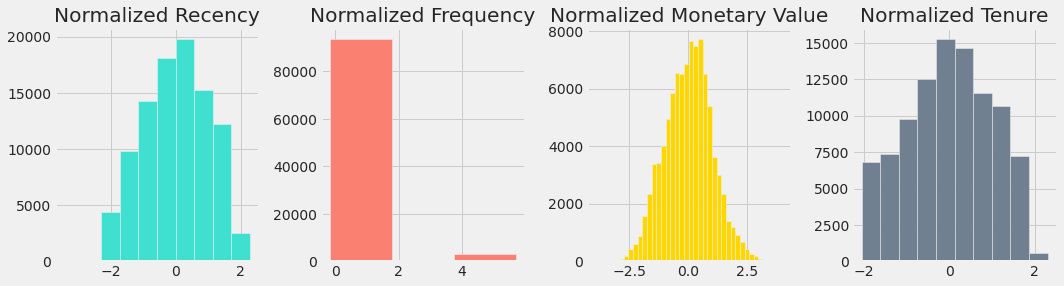

In [36]:
fig, axes = plt.subplots(1, 4, figsize=(16,4))

rfmt_scaled_df.hist('recency', bins=10, color='turquoise', ax=axes[0])
rfmt_scaled_df.hist('frequency', bins=3, color='salmon', ax=axes[1])
rfmt_scaled_df.hist('monetary_value', bins=40, color='gold',ax=axes[2])
rfmt_scaled_df.hist('tenure', bins=10, color='slategray',ax=axes[3])

axes[0].set_title('Normalized Recency')
axes[1].set_title('Normalized Frequency')
axes[2].set_title('Normalized Monetary Value')
axes[3].set_title('Normalized Tenure')

### Optimal K

Text(0, 0.5, 'Squared Standard Error')

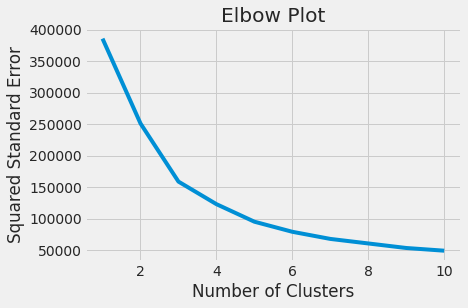

In [37]:
sse={}
for k in range(1,11):
  kmeans = KMeans(n_clusters=k, random_state=1111)
  kmeans.fit(rfmt_scaled_df)
  sse[k] = kmeans.inertia_

sns.lineplot(x=list(sse.keys()), y=list(sse.values()))
plt.title('Elbow Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Squared Standard Error')

Using the elbow method, the optimal number of clusters is 3 or 4, after which we have diminishing returns to SSE. Let's try both and compare. 

### Fit

#### 3 Clusters

In [38]:
kmeans = KMeans(n_clusters=3, random_state=1111)
kmeans.fit(rfmt_scaled_df)
cluster_labels = kmeans.labels_

rfmt_3_clusters = rfmt.assign(cluster = cluster_labels) # add cluster column to original rfm dataframe
rfmt_3_clusters.groupby(['cluster']) \
              .agg({
                    'recency':'mean',
                    'frequency':'mean',
                    'monetary_value':['mean','count'],
                    'tenure':'mean'
                    }).round(0)

recency frequency monetary_value        tenure
           mean      mean           mean  count   mean
cluster                                               
0         396.0       1.0          157.0  48599  409.0
1         146.0       1.0          162.0  44995  158.0
2         298.0       2.0          164.0   2875  311.0

#### 4 Clusters

In [39]:
kmeans = KMeans(n_clusters=4, random_state=1111)
kmeans.fit(rfmt_scaled_df)
cluster_labels = kmeans.labels_

rfmt_4_clusters = rfmt.assign(cluster = cluster_labels) # add cluster column to original rfm dataframe
rfmt_4_clusters.groupby(['cluster']) \
              .agg({
                    'recency':'mean',
                    'frequency':'mean',
                    'monetary_value':['mean','count'],
                    'tenure':'mean'
                    }).round(0)

recency frequency monetary_value        tenure
           mean      mean           mean  count   mean
cluster                                               
0         380.0       1.0          256.0  29330  394.0
1         131.0       1.0          158.0  37670  143.0
2         298.0       2.0          164.0   2875  311.0
3         365.0       1.0           56.0  26594  378.0

While the 3 cluster segementation is simpler, 4 clusters provides more insight, better separating monetary values on the low and high ends. Cluster 2 stands out in size as a small group of higher frequency buyers.  

- Cluster 0: weak recency, highest spend, longest tenure customers

- Cluster 1: strongest recency, moderate spend customers

- Cluster 2: small group of higher frequency, moderate spend customers

- Cluster 3: weak recency, lowest spend customers 

## 7. Segments

### Snake Plot

Text(0.5, 1.0, 'Snake Plot of Standardized RFMT')

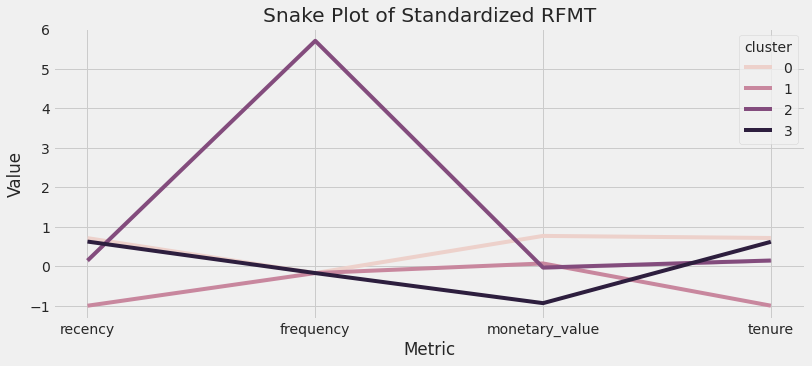

In [43]:
rfmt_scaled_df['cluster'] = rfmt_4_clusters['cluster']

# Melt to long format for easier plotting
rfmt_melted = pd.melt(rfmt_scaled_df.reset_index(), 
                      id_vars = ['customer_id', 'cluster'],
                      value_vars = ['recency','frequency','monetary_value','tenure'],
                      var_name = 'Metric',
                      value_name = 'Value')

plt.figure(figsize=(12,5))
sns.lineplot(x='Metric', y='Value', hue='cluster', data=rfmt_melted)
plt.title('Snake Plot of Standardized RFMT')

The snake plot visualizes the differences between the clusters. For example, we can more easily see higher frequency Cluster 2, low monetary value Cluster 3, and high monetary value Cluster 0. 

### Relative Importance of Segment Metrics

To understand the importance of each metric to each segment relative to the population, let's calculate relative importance. The farther the ratio is from 0, the higher the metric's importance for that segment compared to the population average. 

Text(0.5, 1.0, 'Relative Importance of Metric')

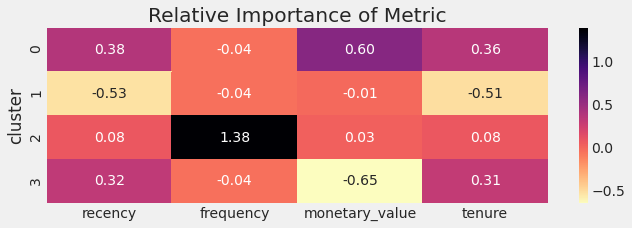

In [49]:
cluster_avg = rfmt_4_clusters.groupby(['cluster']).mean()
population_avg = rfmt.mean()
relative_importance = cluster_avg / population_avg - 1

plt.figure(figsize=(10,3))
sns.heatmap(data=relative_importance, annot=True, fmt='.2f', cmap='magma_r')
plt.title('Relative Importance of Metric')

Recency is particulary important for Cluster 1, frequency for Cluster 2, monetary value for Cluster 0 and Cluster 3, and tenure for Cluster 1.

Based on our understanding customer segment purchasing behavior, we can better tailor product, sales, and marketing activities and investments. 

## 8. References

https://learn.datacamp.com/courses/customer-segmentation-in-python

https://www.geeksforgeeks.org/box-cox-transformation-using-python/

https://en.wikipedia.org/wiki/Power_transform#Box%E2%80%93Cox_transformation

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html